In [1]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:

# =========================
# 1) Portable image loading
# =========================
def find_data_dir(start: Path | None = None) -> Path:
    start = start or Path.cwd()
    for p in [start, *start.parents]:
        d = p / "data"
        if d.is_dir():
            return d
    raise FileNotFoundError("Cannot find 'data/' folder (expected HW/data/...)")

def read_gray_u8(filename: str) -> np.ndarray:
    data_dir = find_data_dir()
    path = (data_dir / filename).resolve()
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Cannot read image: {path}")
    print("Loaded:", path)
    return img



In [3]:
# =========================
# 2) Block matching (SSD)
# =========================
def match_block_ssd(Ia: np.ndarray, Ib: np.ndarray, x0: int, y0: int, w: int, search: int = 50):
    """
    Returns dx, dy in pixel units (NO normalization)
    """
    H, W = Ia.shape
    tpl = Ia[y0:y0+w, x0:x0+w]

    sx0 = max(0, x0 - search)
    sy0 = max(0, y0 - search)
    sx1 = min(W - w, x0 + search)
    sy1 = min(H - w, y0 + search)

    if sx1 < sx0 or sy1 < sy0:
        return 0, 0

    region = Ib[sy0:sy1 + w, sx0:sx1 + w]
    res = cv2.matchTemplate(region, tpl, cv2.TM_SQDIFF)
    _, _, min_loc, _ = cv2.minMaxLoc(res)

    xb = sx0 + min_loc[0]
    yb = sy0 + min_loc[1]
    dx = xb - x0
    dy = yb - y0
    return dx, dy

In [4]:
# =========================
# 3) Motion field from trucka basis
# =========================
def compute_motion_field(Ia: np.ndarray, Ib: np.ndarray, w: int, search: int = 50, stride: int | None = None):
    if stride is None:
        stride = w

    H, W = Ia.shape
    xs = list(range(0, W - w + 1, stride))
    ys = list(range(0, H - w + 1, stride))

    U = np.zeros((len(ys), len(xs)), dtype=np.int32)
    V = np.zeros((len(ys), len(xs)), dtype=np.int32)

    Xc, Yc = np.meshgrid(
        np.array(xs) + w / 2,
        np.array(ys) + w / 2
    )

    for i, y0 in enumerate(ys):
        for j, x0 in enumerate(xs):
            dx, dy = match_block_ssd(Ia, Ib, x0, y0, w, search)
            U[i, j] = dx
            V[i, j] = dy

    return U, V, Xc, Yc


In [5]:
# =========================
# 4) Plot ONLY vectors (NO autoscale)
# =========================
def show_quiver_raw(Xc, Yc, U, V, H, W, title="", grid_step=16):
    fig = plt.figure(figsize=(10, 6), facecolor="white")
    ax = fig.add_axes([0, 0, 1, 1])

    ax.set_xlim(0, W)
    ax.set_ylim(H, 0)          # image coordinate
    ax.set_aspect("equal")

    ax.set_title(title)
    ax.set_xticks(np.arange(0, W+1, grid_step))
    ax.set_yticks(np.arange(0, H+1, grid_step))
    ax.grid(True, linewidth=0.3)

    # KEY PART: raw pixel vectors
    ax.quiver(
        Xc, Yc, U, V,
        angles="xy",
        scale_units="xy",
        scale=1,          # <-- NO AUTOSCALE
        pivot="middle",
        width=0.002
    )

    plt.show()

Loaded: D:\NTUST\Study\Advanced Computer Vision\HW\HW1\data\trucka.bmp
Loaded: D:\NTUST\Study\Advanced Computer Vision\HW\HW1\data\truckb.bmp


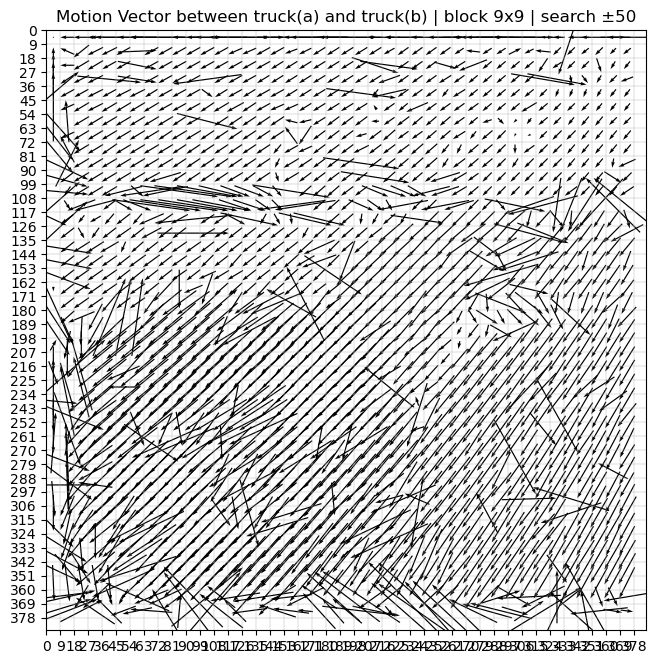

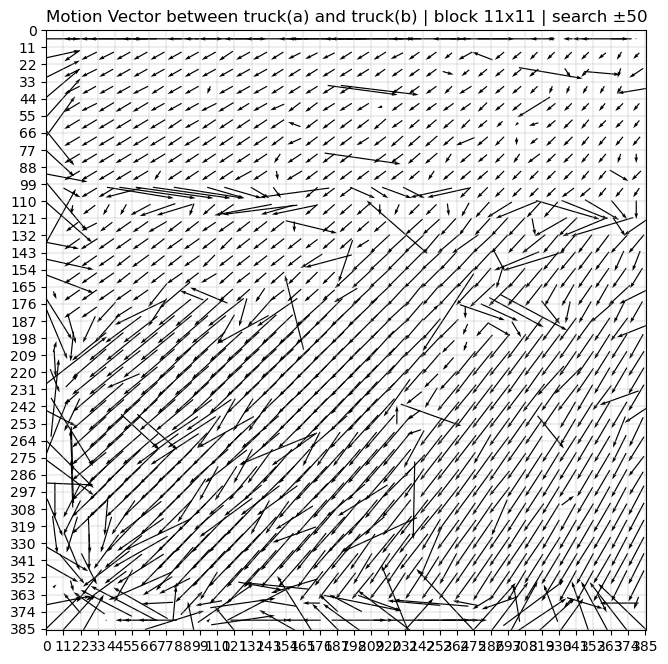

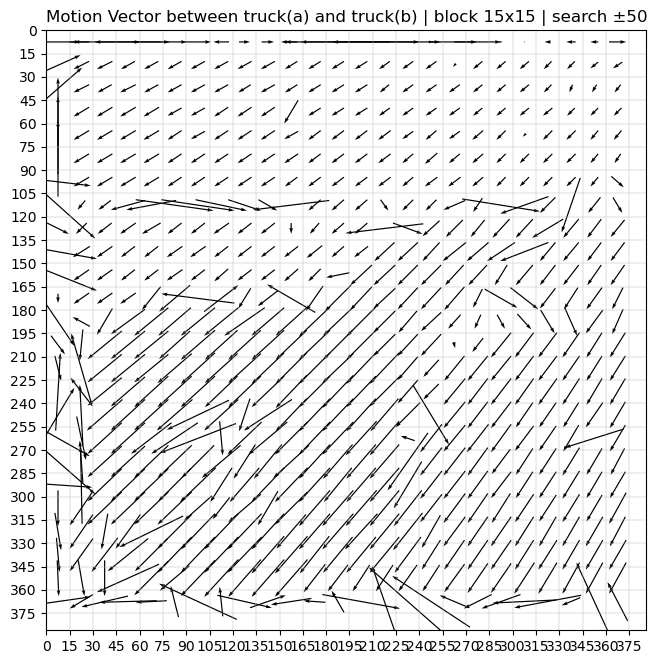

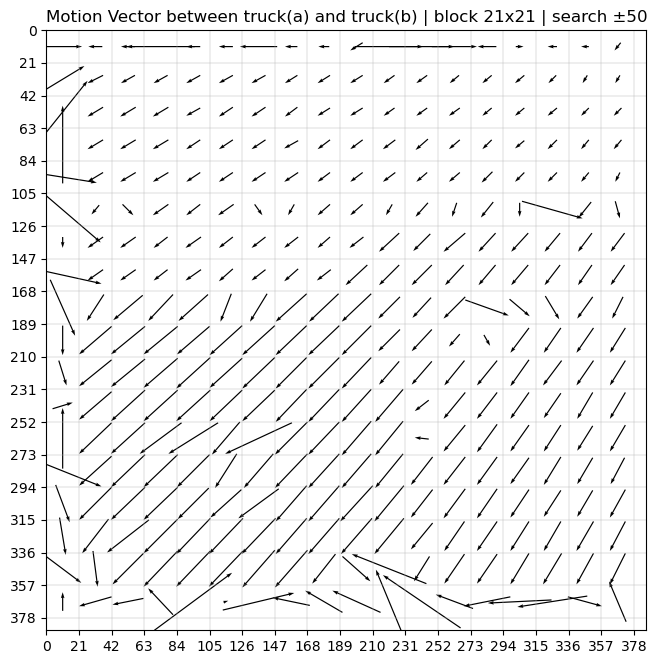

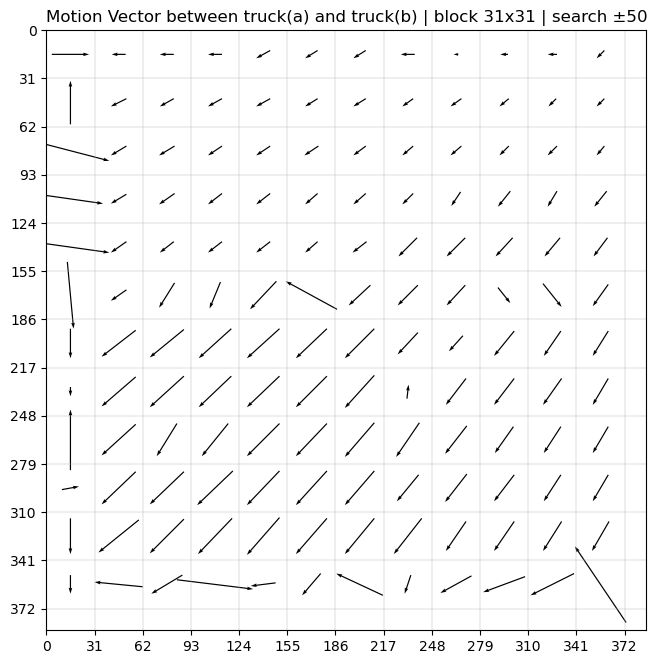

In [6]:
# =========================
# 5) Run (required block sizes)
# =========================
truck_a = read_gray_u8("trucka.bmp")
truck_b = read_gray_u8("truckb.bmp")
H, W = truck_a.shape

block_sizes = [9, 11, 15, 21, 31]
search_range = 50

for w in block_sizes:
    U, V, Xc, Yc = compute_motion_field(
        truck_a, truck_b,
        w=w,
        search=search_range,
        stride=w
    )

    show_quiver_raw(
        Xc, Yc, U, V,
        H, W,
        title=f"Motion Vector between truck(a) and truck(b) | block {w}x{w} | search ±{search_range}",
        grid_step=w
    )